# CAB420 - Plot Gallery
## Part 3: Classification Plots
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

This is part 3 of the plot gallery. This one focuses on classification, and the sort of plots that you might use for this. The overview here is very brief as the main details really are all below with each plot.

In [1]:
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import numpy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn
from sklearn.manifold import TSNE

## Making some fake data, and then some classifiers

Cause we need something to classify, and then some results to plot.

In [2]:
# make some random binary data, and split into train and test
X_binary, y_binary = make_classification(random_state=42, n_samples=2000, n_features=20, n_informative=5, n_redundant=2, n_repeated=0, n_classes=2, n_clusters_per_class=5)
X_binary_train, X_binary_test, y_binary_train, y_binary_test = train_test_split(X_binary, y_binary, train_size=0.7, random_state=42)
# make some random multi-class data, and split into train and test
X_multi, y_multi = make_classification(random_state=42, n_samples=2000, n_features=20, n_informative=5, n_redundant=2, n_repeated=0, n_classes=5, n_clusters_per_class=2)
X_multi_train, X_multi_test, y_multi_train, y_multi_test = train_test_split(X_multi, y_multi, train_size=0.7, random_state=42)

# train some classifiers
rf_binary = RandomForestClassifier(n_estimators=1000, max_depth=None).fit(X_binary_train, y_binary_train)
rf_multi = RandomForestClassifier(n_estimators=1000, max_depth=None).fit(X_multi_train, y_multi_train)

# get some predictions from those classifiers
pred_binary_train = rf_binary.predict(X_binary_train)
proba_binary_train = rf_binary.predict_proba(X_binary_train)
pred_binary_test = rf_binary.predict(X_binary_test)
proba_binary_test = rf_binary.predict_proba(X_binary_test)

pred_multi_train = rf_multi.predict(X_multi_train)
proba_multi_train = rf_multi.predict_proba(X_multi_train)
pred_multi_test = rf_multi.predict(X_multi_test)
proba_multi_test = rf_multi.predict_proba(X_multi_test)

Note that we have two types of predictions out of the random forest:
* Using `predict`, we just get a class prediction. For each input sample, we get a single value indicating what class the sample has been classified as.
* Using `predict_proba`, we get a vector out for each input, with the length of the vector equal to the number of classes. The values within the vector give us the likelihood of each sample belonging to each class. This is essentially the same output that we get from a softmax output with a deep neural network.

Finally, applying an argmax across the rows of the probabilistic outputs we can see we get the exact same results as what comes out of `predict`.

In [3]:
# class predictions
print(numpy.shape(pred_multi_test))
print(pred_multi_test[0:5])

# probabalistic predictions
print(numpy.shape(proba_multi_test))
print(proba_multi_test[0:5,:])

# confirm that they are the same thing
print((numpy.argmax(proba_multi_test, axis=1) == pred_multi_test).all())

(600,)
[4 3 2 2 4]
(600, 5)
[[0.073 0.016 0.056 0.094 0.761]
 [0.058 0.013 0.294 0.547 0.088]
 [0.17  0.04  0.562 0.14  0.088]
 [0.136 0.056 0.389 0.11  0.309]
 [0.059 0.187 0.263 0.076 0.415]]
True


### Confusion Matrix (Binary)

Text(0.5, 1.0, 'Full Normalisation')

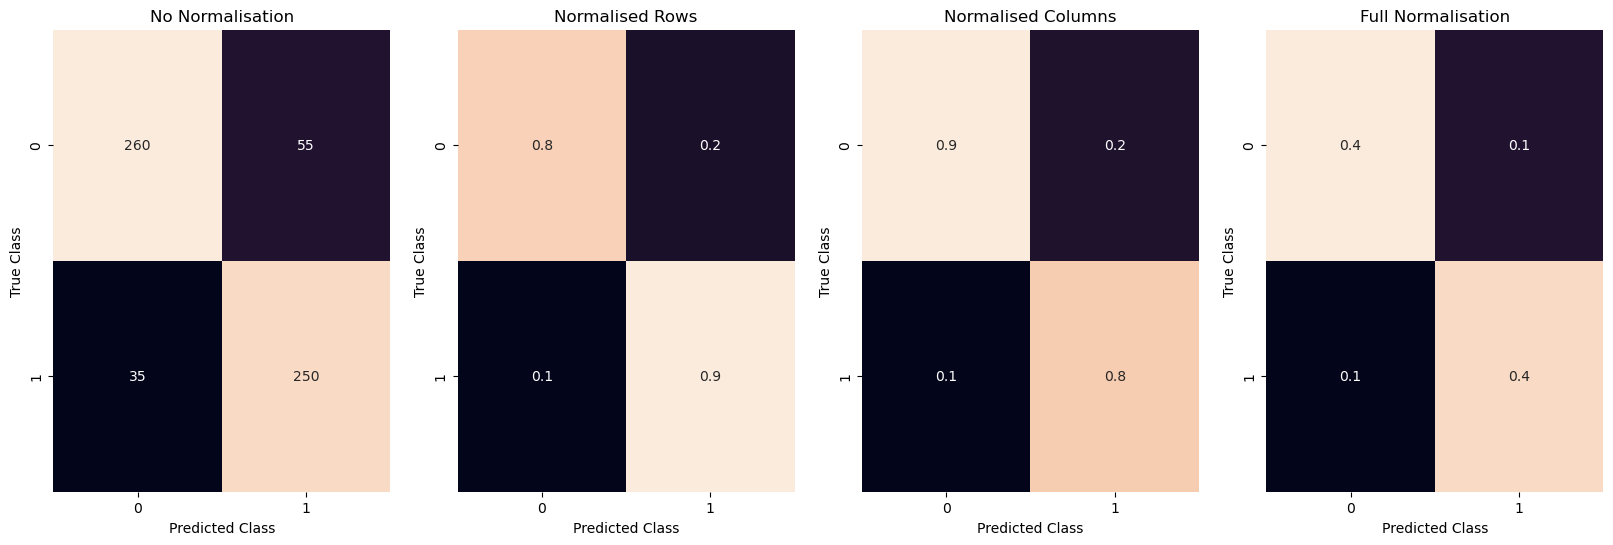

In [4]:
fig = plt.figure(figsize=[20, 6])
ax = fig.add_subplot(1, 4, 1)
seaborn.heatmap(confusion_matrix(y_binary_test, pred_binary_test), ax=ax, annot=True, fmt='d', cbar=False)
ax.set_ylabel('True Class')
ax.set_xlabel('Predicted Class')
ax.set_title('No Normalisation')

ax = fig.add_subplot(1, 4, 2)
seaborn.heatmap(confusion_matrix(y_binary_test, pred_binary_test, normalize='true'), ax=ax, annot=True, fmt='.1f', cbar=False)
ax.set_ylabel('True Class')
ax.set_xlabel('Predicted Class')
ax.set_title('Normalised Rows')

ax = fig.add_subplot(1, 4, 3)
seaborn.heatmap(confusion_matrix(y_binary_test, pred_binary_test, normalize='pred'), ax=ax, annot=True, fmt='.1f', cbar=False)
ax.set_ylabel('True Class')
ax.set_xlabel('Predicted Class')
ax.set_title('Normalised Columns')

ax = fig.add_subplot(1, 4, 4)
seaborn.heatmap(confusion_matrix(y_binary_test, pred_binary_test, normalize='all'), ax=ax, annot=True, fmt='.1f', cbar=False)
ax.set_ylabel('True Class')
ax.set_xlabel('Predicted Class')
ax.set_title('Full Normalisation')

**What's it show?**
Classification performance for a binary classifier. True labels are shown on the y-axis, predicted labels are shown on the x-axis. Consider the left most plot. We have the following:
* The top left cell, which shows the number of instances where the true class is 0 and the predicted class is 0, is the number of *True Positives*.
* The top right cell, which shows the number of instances where the true class is 1 and the predicted class is 0, is the number of *False Positives*. 
* The bottom left cell, which shows the number of instanes where the true class is 0 but the predicted class is 1, shows the number *False Negatives*.
* The bottom right cell, where both the predicted and true classes are 1, shows the number of *True Positives*.

Essentially, The numbers on the diagonal running from the top-left to the bottom-right are the correct predictions, everything else is an error. 

We can normalise the data in different ways. Normalising the rows (second from left) such that each row sums to 1 allows to quickly see what percentage of a individual class is classified correctly (i.e. of all the samples that are truly class 1, how many are correct). Normalising the columns (third from left) allows us to see what percentage of predictions for a given class are correct (i.e. of all the things my classifier decided are class 1, how many are correct). We can also normalise the entire thing (far right), which gives us a percentage of samples in each cell. 

**When would you use it?**
When evaluating classifier performance, and to understand the type of errors being made by your system. It can also show issues relating to class imbalance when either raw counts (far left) or full normalisation (far right) are used.

**What does it not show?**
The actual cause of any errors, or any performance metrics (though you can derive a lot of measures such as F1, precision, recall, etc, from the raw counts in each cell on the far left version).

### Confusion Matrix (Multi-Class)

Text(0.5, 1.0, 'Full Normalisation')

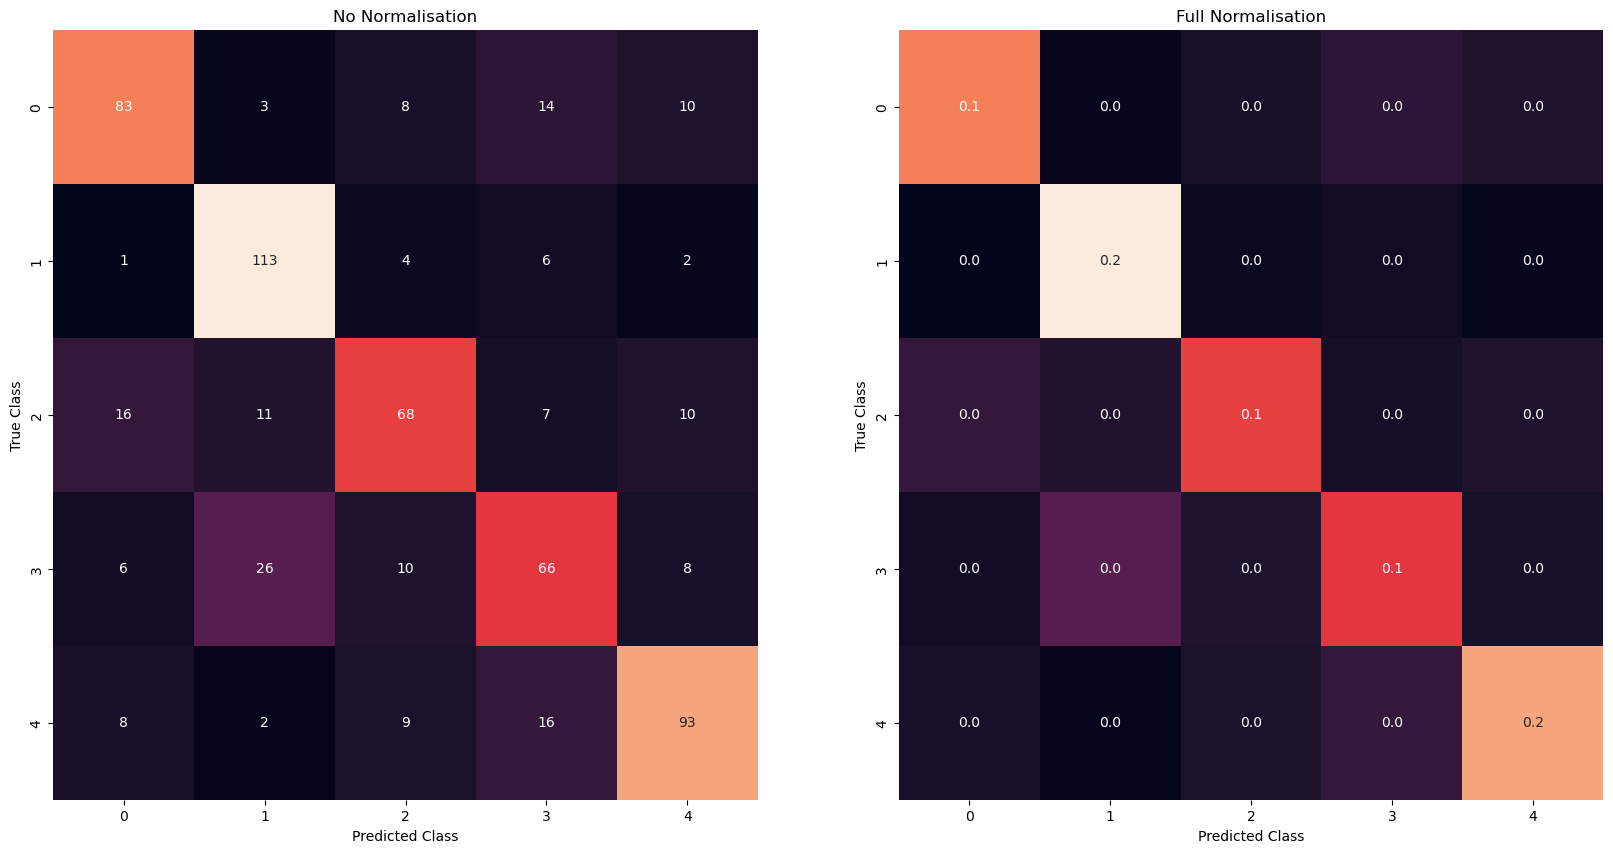

In [5]:
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(1, 2, 1)
seaborn.heatmap(confusion_matrix(y_multi_test, pred_multi_test), ax=ax, annot=True, fmt='d', cbar=False)
ax.set_ylabel('True Class')
ax.set_xlabel('Predicted Class')
ax.set_title('No Normalisation')

ax = fig.add_subplot(1, 2, 2)
seaborn.heatmap(confusion_matrix(y_multi_test, pred_multi_test, normalize='all'), ax=ax, annot=True, fmt='.1f', cbar=False)
ax.set_ylabel('True Class')
ax.set_xlabel('Predicted Class')
ax.set_title('Full Normalisation')

**What's it show?**
Much the same as the previous set of confusion matrices, but now for multiple classes. Correct decisions are still on the top-left to bottom-right diagonal, and different normalisations can still be applied (we're using no normalisation on the left, and full normalisation on the right). False positives and false negatives are now a bit harder to see, but for a given class, all elements except the diagonal element along the relevent row are false negatives for that class; and all elements except the diagonal element along a given column are the false positives for that class. 

**When would you use it?**
When you've got a multi-class classification problem that you want to evaluate. Again it's useful to understand the types of errors being created by your system. In particular, it can help you understand what classes are being confused with each other.

**What does it not show?**
Same as the binary version - the actual causes for errors or any performance metrics.

### ROC Curve

Text(0.5, 1.0, 'Multi-Class ROC Curve')

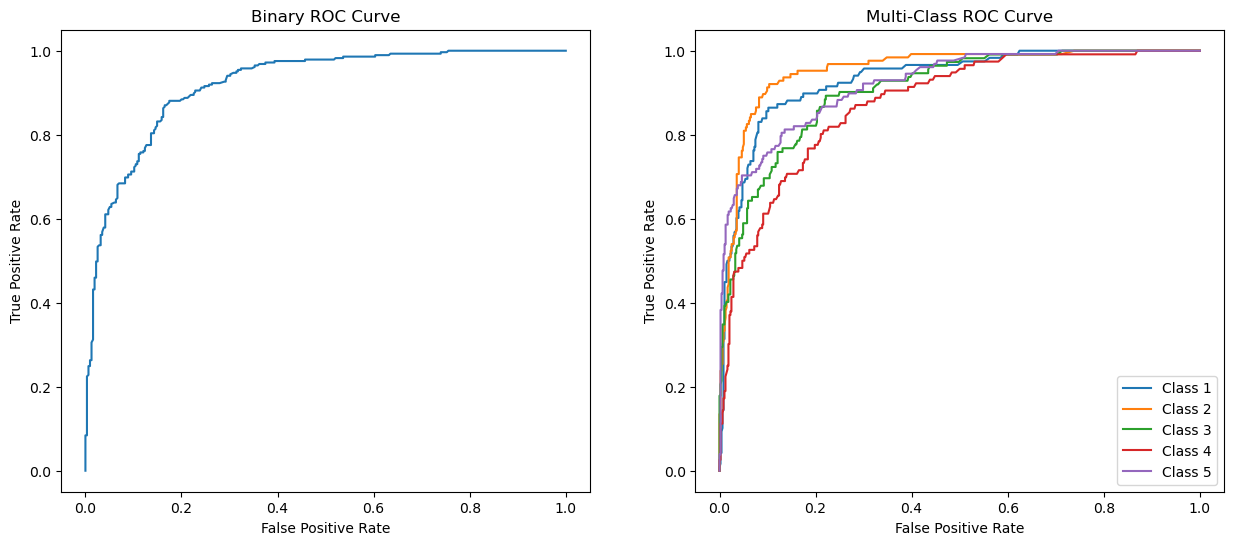

In [6]:
# note we're using the predicted probabilities here. We're passing in the labels, and the probabilities for
# the true class
fpr, tpr, thresholds = roc_curve(y_binary_test, proba_binary_test[:,1])
fig = plt.figure(figsize=[15, 6])
ax = fig.add_subplot(1, 2, 1)
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Binary ROC Curve')

ax = fig.add_subplot(1, 2, 2)
# A multi-class ROC doesn't really exist. What we're instead going to do is plot an ROC for each class vs the 
# rest. As such, we'll iterate through the classes, pass in the likelihood for the class in question, and set
# the positive label as this same class.
for i in range(5):
    fpr, tpr, _ = roc_curve(y_multi_test, proba_multi_test[:,i], pos_label=i)
    ax.plot(fpr, tpr, label='Class %d' % (i+1))
                     
ax.legend()
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Multi-Class ROC Curve')

**What's it show?**
The trade off between false positives and true positives. There is a trade off between these two quantities. To have a higher true positive rate, we need to accept that we've have more false positives. The plot is obtained by evaluating the classification performance at various thresholds. From the code above, you'll see that our input is not the final classification results, but the probability scores. If we apply different thresholds to these, we'll get different results. Low thresholds will lead to high true positive rates, but also high false positive rates; high thresholds will lead to low rates for both. This plot shows the trade off as the threshold is changed. Better classifiers will have a steeper curve and get closer to the top-left corner. A metric associated with this plot is the *Area Under the Curve* (or AUC) which measures the area under the ROC curve (where do they get these names??). An ROC of 1 represents a perfect result.

**When would you use it?**
When comparing two classifiers. You can use this to easily compare models. Whichever has the greater area under the curve, or the higher true positive rate at your desired false negative rate, is the better option. It makes more sense for binary tasks too, as use in a multi-class case is tricky due to each class being analysed independently.

**What does it not show?**
It doesn't show overall performance for a multi-class situation very well, and doesn't give you information about the number of errors being made, or any sort of info on class imbalance like we see with a confusion matrix. It also doesn't show the thresholds - but you can get this back from the `roc_curve` function.

**Is there any data it's bad for?**
It needs a probabilistic output, so if you don't have that, it's not much use. It's also pretty inappropriate for regression.

### Visualising Classification Results 

Text(0.5, 1.0, 'Predicted Class Scatter Plot, TSNE')

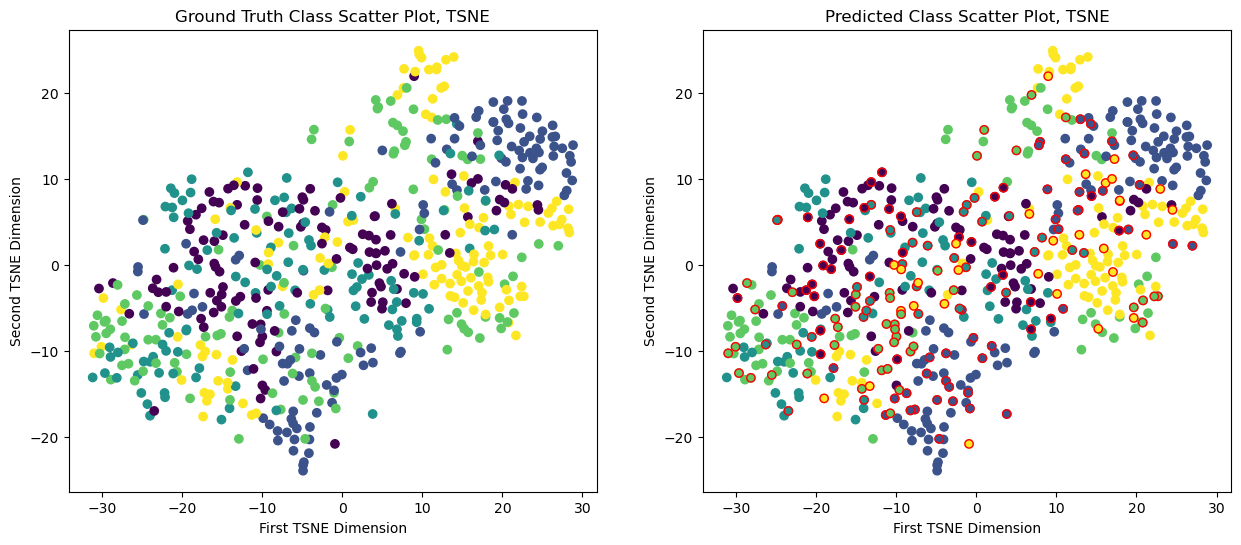

In [7]:
fig = plt.figure(figsize=[15, 6])
ax = fig.add_subplot(1, 2, 1)
X_tsne = TSNE(random_state=42).fit_transform(X_multi_test)
ax.scatter(X_tsne[:,0], X_tsne[:,1], c=y_multi_test)
ax.set_xlabel('First TSNE Dimension')
ax.set_ylabel('Second TSNE Dimension')
ax.set_title('Ground Truth Class Scatter Plot, TSNE')

ax = fig.add_subplot(1, 2, 2)
ax.scatter(X_tsne[:,0], X_tsne[:,1], c=pred_multi_test)
wrong_points = y_multi_test!=pred_multi_test
ax.scatter(X_tsne[wrong_points,0], X_tsne[wrong_points,1], c=pred_multi_test[wrong_points], edgecolors='red')
ax.set_xlabel('First TSNE Dimension')
ax.set_ylabel('Second TSNE Dimension')
ax.set_title('Predicted Class Scatter Plot, TSNE')

**What's it show?**
The ground truth and predicted results for the test set, mapped to two dimensions using TSNE. The predicted class plot also shows errors with a red ring of doom around the offending points. This plot is really another version of what we looked at at the end of Part 1 (Data Exploration).

**When would you use it?**
To visualise classifier performance, and help understand why errors are being made. For misclassified points that lie near one another, there are understandable reasons as to why such a point might be misclassified. You can also look at the distribution on the training set to try and understand any differences between the two datasets.

**What does it not show?**
The actual decision boundaries, or clearly showing the nature of the misclassifications like a confusion matrix does.

**Is there any data it's bad for?**
With lots of points, and/or large numbers of classes it may become a bit hard to interpret. TSNE also has it's quirks, as it's estimating a low dimensional verison of the high dimension distribution. As per the Part 1 example, PCA and just using raw dimensions are other options here, but they have their own limiations - particularly once the number of dimensions starts to increase.

### Visualising Classifier Decision Boundaries

We're not showing this. I know plots for this are in an early classifier example, but:
* Those plots are using toy 2D data
* Such plots scale very badly to high dimensional data spaces, but due to the challenges in visualising this data, but also in computing the decision space